<div style="text-align: center;">
  
# 🧁 Limpeza e tratamento de dados de CGM (monitoramento contínuo de glicemia)

</div>

## 1. Carregando as bibliotecas

In [1]:
#%pip install missingno

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 2. Extraindo e visualizando o dataframe; padronizando os nomes das variáveis; certificando os tipos de dados

In [3]:
# Dataset extraído pelo RStudio através do repositório 
# https://rdrr.io/github/personalscience/psi-shiny-cgm/man/sample_libreview_df.html
df_extract = pd.read_csv('./sample_libreview_df_raw.csv')
df_raw = df_extract.copy()

df_raw

,Unnamed: 0,time,scan,hist,strip,value,food,user_id
0,1,2021-05-30 16:59:00,NaN,69.0,NaN,69.0,NaN,1234
1,2,2021-05-30 17:14:00,NaN,66.0,NaN,66.0,NaN,1234
2,3,2021-05-30 17:30:00,NaN,62.0,NaN,62.0,NaN,1234
3,4,2021-05-30 17:45:00,NaN,60.0,NaN,60.0,NaN,1234
4,5,2021-05-30 18:00:00,NaN,62.0,NaN,62.0,NaN,1234
...,...,...,...,...,...,...,...,...
3979,3980,2021-07-12 19:27:00,NaN,NaN,NaN,NaN,NaN,1234
3980,3981,2021-07-13 11:25:00,NaN,NaN,NaN,NaN,NaN,1234
3981,3982,2021-07-15 14:17:00,NaN,NaN,NaN,NaN,NaN,1234
3982,3983,2021-07-16 09:31:00,NaN,NaN,NaN,NaN,NaN,1234


In [4]:
'''
No atributo columns (do tipo índice) do objeto df_raw, nosso dataframe, iremos formatar
todos os seus elementos, isto é, os nomes das colunas. Para isso, utilizamos o acessor .str, 
que nos permite aplicar métodos de strings para todos os elementos do índice/vetor.
Os métodos utilizados são: 
- lower(): torna todos os caracteres minúsculos;
- strip(): remove espaços em branco das extremidades da string;
- replace(,): substituímos o elemento da esquerda, sempre que ele aparecer, pelo da 
direita. No nosso caso, trocamos um espaço em branco por nenhum espaço, e ":" por nenhum espaço.
'''

df_raw.columns = df_raw.columns.str.lower().str.strip().str.replace(' ', '').str.replace(':', '')

In [5]:
# convertemoscoluna 'time' para o tipo datetime
df_raw['time'] = pd.to_datetime(df_raw['time'], errors = 'coerce') 
# a coluna 'value' se torna numérica
df_raw['value'] = pd.to_numeric(df_raw['value'], errors = 'coerce') 

# OBS: errors = 'coerce' faz com que elementos que não estejam num formato válido para
# serem convertidos para datetime retornem NaT, e os que não possam ser convertidos para
# int ou float (numérico) retornem NaN.
df_raw

,unnamed0,time,scan,hist,strip,value,food,user_id
0,1,2021-05-30 16:59:00,NaN,69.0,NaN,69.0,NaN,1234
1,2,2021-05-30 17:14:00,NaN,66.0,NaN,66.0,NaN,1234
2,3,2021-05-30 17:30:00,NaN,62.0,NaN,62.0,NaN,1234
3,4,2021-05-30 17:45:00,NaN,60.0,NaN,60.0,NaN,1234
4,5,2021-05-30 18:00:00,NaN,62.0,NaN,62.0,NaN,1234
...,...,...,...,...,...,...,...,...
3979,3980,2021-07-12 19:27:00,NaN,NaN,NaN,NaN,NaN,1234
3980,3981,2021-07-13 11:25:00,NaN,NaN,NaN,NaN,NaN,1234
3981,3982,2021-07-15 14:17:00,NaN,NaN,NaN,NaN,NaN,1234
3982,3983,2021-07-16 09:31:00,NaN,NaN,NaN,NaN,NaN,1234


## 3. Atribuindo valores reais (esquecidos) a 'value', seguindo a hierarquia entre 'strip', 'scan' e 'hist'

In [6]:
def value_herda_exclui(df, col_time='time', col_alvo='value', col1='strip', col2='scan', col3='hist'):
    """
    Preenche os NaNs de `col_alvo` com prioridade:
    1. Usa `col1` se disponível.
    2. Caso contrário, usa `col2`.
    3. Caso contrário, usa `col3`.
    """
    
    df = df.copy()
    
    # 0 = não foi preenchido por outra coluna, 1 foi por col1, 2 por col2 e 3 por col3.
    df['preenchido_por'] = 0

    # vetores (Series), onde: o primeiro tem valores True nos índices em que col_alvo é NaN; 
    # o segundo tem valores True onde col1 não é NaN
    cond1 = df[col_alvo].isna() & df[col1].notna() 
    # faço a substituição nessas posições
    df.loc[cond1, col_alvo] = df.loc[cond1, col1]
    df.loc[cond1, 'preenchido_por'] = 1

    # Faço o mesmo com as linhas restantes de col_alvo que continuam NaN, mas agora
    # comparando com os valores de col2 e col3
    cond2 = df[col_alvo].isna() & df[col2].notna()
    df.loc[cond2, col_alvo] = df.loc[cond2, col2]
    df.loc[cond2, 'preenchido_por'] = 2

    cond3 = df[col_alvo].isna() & df[col3].notna()
    df.loc[cond3, col_alvo] = df.loc[cond3, col3]
    df.loc[cond3, 'preenchido_por'] = 3

    # Agora, vamos ordenar por prioridade e eliminar duplicatas no tempo
    df[col_time] = pd.to_datetime(df[col_time], errors = 'coerce') 
    df = df.sort_values(by=[col_time, 'preenchido_por'])  # menor preenchido_por tem maior prioridade
    df = df.drop_duplicates(subset=col_time, keep='first').reset_index(drop=True)

    # Removo a coluna que indica de qual medição o value foi advindo
    df = df.drop(columns=['preenchido_por'])

    return df

df_raw = value_herda_exclui(df_raw)
df_raw

,unnamed0,time,scan,hist,strip,value,food,user_id
0,3883,2021-05-30 15:57:00,NaN,NaN,NaN,NaN,NaN,1234
1,3884,2021-05-30 16:58:00,NaN,NaN,NaN,NaN,NaN,1234
2,1,2021-05-30 16:59:00,NaN,69.0,NaN,69.0,NaN,1234
3,3885,2021-05-30 17:02:00,NaN,NaN,NaN,NaN,NaN,1234
4,2,2021-05-30 17:14:00,NaN,66.0,NaN,66.0,NaN,1234
...,...,...,...,...,...,...,...,...
3863,3560,2021-07-20 07:10:00,NaN,80.0,NaN,80.0,NaN,1234
3864,3561,2021-07-20 07:25:00,NaN,83.0,NaN,83.0,NaN,1234
3865,3562,2021-07-20 07:40:00,NaN,82.0,NaN,82.0,NaN,1234
3866,3879,2021-07-20 07:59:00,88.0,NaN,NaN,88.0,NaN,1234


## 4. Removendo as variáveis restantes e, agora, desnecessárias

In [7]:
# Eliminando as colunas que não serão utilizadas
df_raw = df_raw.drop(columns=['unnamed0', 'strip', 'hist', 'scan', 'food', 'user_id'])

df_raw

,time,value
0,2021-05-30 15:57:00,NaN
1,2021-05-30 16:58:00,NaN
2,2021-05-30 16:59:00,69.0
3,2021-05-30 17:02:00,NaN
4,2021-05-30 17:14:00,66.0
...,...,...
3863,2021-07-20 07:10:00,80.0
3864,2021-07-20 07:25:00,83.0
3865,2021-07-20 07:40:00,82.0
3866,2021-07-20 07:59:00,88.0


## 5. Eliminando os valores nulos e absurdos

In [8]:
# Contagem de quantos valores nulos (NaN ou NaT) temos em cada coluna de df_raw
# df_raw.isnull() retorna um dataframe com True e False em cada célula. True, se a célula tem
# valor NaN ou NaT, e False em caso contrário. O método sum(axis = 0) soma a quantidade de cada coluna.
# Como True corresponde ao valor 1 e False a 0, teremos assim a soma dos valores nulos.

print('Valores nulos antes: \n')
print(df_raw.isnull().sum(axis = 0))

Valores nulos antes: 

time      1
value    97
dtype: int64


In [9]:
def elimina_nulos_ruidos(df, col_time='time', col_value='value', lim_inf=0, lim_sup=500, minutes_rel1=15, minutes_rel2=15, ruido_rel=50):
    '''Documentação'''

    df = df.copy()

    # Garantir os tipos de dados
    df_raw['time'] = pd.to_datetime(df_raw['time'], errors = 'coerce') 
    df_raw['value'] = pd.to_numeric(df_raw['value'], errors = 'coerce') 

    # Excluindo as linhas em que 'time' ou 'value' tem valor nulo
    df = df.dropna(subset=[col_time,col_value])

    # Excluindo as linhas em que 'value' tem um possível ruído absoluto
    df = df[(df[col_value] > lim_inf) & (df[col_value] < lim_sup)]

    # Excluindo as linhas em que 'value' tem um possível ruído relativo
    df['diff_prev'] = df[col_value].diff().abs() # diferença de valor para a linha anterior
    df['diff_next'] = df[col_value].diff(-1).abs() # diferença de valor para a linha posterior

    df['delta_prev'] = df[col_time] - df[col_time].shift(1) # diferença de tempo para a linha anterior
    df['delta_next'] = df[col_time].shift(-1) - df[col_time] # diferença de tempo para a linha posterior

    mask_delta_prev = df['delta_prev'] <= pd.Timedelta(minutes=minutes_rel1)
    mask_delta_next = df['delta_next'] <= pd.Timedelta(minutes=minutes_rel2)

    mask_ruido_duplo = (df['diff_prev'] > ruido_rel) & mask_delta_prev & \
                    (df['diff_next'] > ruido_rel) & mask_delta_next

    df = df.loc[~mask_ruido_duplo]
    df.drop(columns=['diff_prev', 'diff_next', 'delta_prev', 'delta_next'], inplace=True)

    # Organizando o dataframe por 'time' crescente, e resetando os índices, já que
    # ao excluirmos linhas, a linha com o índice é excluída. Agora, temos índices ordenados e
    # sequenciados novamente de 0 ao fim do dataframe.
    df = df.sort_values(by=col_time).reset_index(drop=True) 

    return df

# Esse é o dataframe apenas com dados medidos
df_raw = elimina_nulos_ruidos(df_raw)
df_raw


,time,value
0,2021-05-30 16:59:00,69.0
1,2021-05-30 17:14:00,66.0
2,2021-05-30 17:30:00,62.0
3,2021-05-30 17:45:00,60.0
4,2021-05-30 18:00:00,62.0
...,...,...
3765,2021-07-20 06:55:00,77.0
3766,2021-07-20 07:10:00,80.0
3767,2021-07-20 07:25:00,83.0
3768,2021-07-20 07:40:00,82.0


## 6. Subdivisão de 'time' em 'date', 'hour', 'hour_minute', 'weekday' e 'hour_cont'

In [10]:
def dividir_time(df, col_time='time'):
    """
    Adiciona colunas derivadas de tempo para análise estatística e manipulação temporal.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame com uma coluna datetime.
    col_time : str, default 'time'
        Nome da coluna que contém timestamps (deve ser do tipo datetime ou conversível).
    Retorna:
    --------
    pd.DataFrame
        DataFrame com as colunas adicionais:
            - 'date' : data (sem horário)
            - 'hour' : hora inteira
            - 'hour_minute' : string com hora e minuto no formato HH:MM
            - 'weekday' : nome do dia da semana
            - 'hour_cont' : hora com fração decimal (ex: 14.25 para 14:15)
    """
    df = df.copy()

    df[col_time] = pd.to_datetime(df[col_time])

    df['date'] = pd.to_datetime(df[col_time].dt.date)  # <- corrigido aqui
    primeiro_dia = df['date'].min()
    df['date_cont'] = (df['date'] - primeiro_dia).dt.days  # <- agora funciona

    df['hour'] = df[col_time].dt.hour
    df['hour_minute'] = df[col_time].dt.strftime('%H:%M')
    df['weekday'] = df[col_time].dt.day_name()
    df['hour_cont'] = (df[col_time].dt.hour + df[col_time].dt.minute / 60).round(2)

    return df

df_raw = dividir_time(df_raw)
df_raw

,time,value,date,date_cont,hour,hour_minute,weekday,hour_cont
0,2021-05-30 16:59:00,69.0,2021-05-30,0,16,16:59,Sunday,16.98
1,2021-05-30 17:14:00,66.0,2021-05-30,0,17,17:14,Sunday,17.23
2,2021-05-30 17:30:00,62.0,2021-05-30,0,17,17:30,Sunday,17.50
3,2021-05-30 17:45:00,60.0,2021-05-30,0,17,17:45,Sunday,17.75
4,2021-05-30 18:00:00,62.0,2021-05-30,0,18,18:00,Sunday,18.00
...,...,...,...,...,...,...,...,...
3765,2021-07-20 06:55:00,77.0,2021-07-20,51,6,06:55,Tuesday,6.92
3766,2021-07-20 07:10:00,80.0,2021-07-20,51,7,07:10,Tuesday,7.17
3767,2021-07-20 07:25:00,83.0,2021-07-20,51,7,07:25,Tuesday,7.42
3768,2021-07-20 07:40:00,82.0,2021-07-20,51,7,07:40,Tuesday,7.67


In [11]:
colunas_ordenadas = ['time', 'date', 'date_cont', 'hour_minute', 'value', 'weekday', 'hour', 'hour_cont']
df_raw = df_raw[colunas_ordenadas]


## 7. Organização final da tabela

In [12]:
# Organização final da tabela de valores reais
def faixa_horaria(hora):
    if 0 <= hora <= 6:
        return 'small_hours'
    elif 7 <= hora <= 12:
        return 'morning'
    elif 13 <= hora <= 17:
        return 'afternoon'
    elif 18 <= hora <= 21:
        return 'dinner'
    else:
        return 'late_night'

df_raw.loc[:, 'time_of_day'] = df_raw['hour'].apply(faixa_horaria)
df_raw


C:\Users\laris\AppData\Local\Temp\ipykernel_36028\3496831491.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw.loc[:, 'time_of_day'] = df_raw['hour'].apply(faixa_horaria)


,time,date,date_cont,hour_minute,value,weekday,hour,hour_cont,time_of_day
0,2021-05-30 16:59:00,2021-05-30,0,16:59,69.0,Sunday,16,16.98,afternoon
1,2021-05-30 17:14:00,2021-05-30,0,17:14,66.0,Sunday,17,17.23,afternoon
2,2021-05-30 17:30:00,2021-05-30,0,17:30,62.0,Sunday,17,17.50,afternoon
3,2021-05-30 17:45:00,2021-05-30,0,17:45,60.0,Sunday,17,17.75,afternoon
4,2021-05-30 18:00:00,2021-05-30,0,18:00,62.0,Sunday,18,18.00,dinner
...,...,...,...,...,...,...,...,...,...
3765,2021-07-20 06:55:00,2021-07-20,51,06:55,77.0,Tuesday,6,6.92,small_hours
3766,2021-07-20 07:10:00,2021-07-20,51,07:10,80.0,Tuesday,7,7.17,morning
3767,2021-07-20 07:25:00,2021-07-20,51,07:25,83.0,Tuesday,7,7.42,morning
3768,2021-07-20 07:40:00,2021-07-20,51,07:40,82.0,Tuesday,7,7.67,morning


<div style="text-align: center;">
  
# 🔍 Análise Exploratória de Dados

</div>

## 1. Informações da tabela df_raw

In [13]:
print('Quantidade de linhas e colunas:\n', df_raw.shape, '\n\n---\n')
print('Colunas presentes:\n', df_raw.columns, '\n---\n')
print('Tipo de dados:\n', df_raw.dtypes, '\n\n---\n')
print('Quantidade de dados únicos:\n', df_raw.nunique())

Quantidade de linhas e colunas:
 (3770, 9) 

---

Colunas presentes:
 Index(['time', 'date', 'date_cont', 'hour_minute', 'value', 'weekday', 'hour',
       'hour_cont', 'time_of_day'],
      dtype='object') 
---

Tipo de dados:
 time           datetime64[ns]
date           datetime64[ns]
date_cont               int64
hour_minute            object
value                 float64
weekday                object
hour                    int32
hour_cont             float64
time_of_day            object
dtype: object 

---

Quantidade de dados únicos:
 time           3770
date             45
date_cont        45
hour_minute    1372
value           122
weekday           7
hour             24
hour_cont      1372
time_of_day       5
dtype: int64


## 2. Estatísticas gerais da variável 'value' e sua distribuição de frequências absolutas

In [14]:
df_raw['value'].describe().round(1)

count    3770.0
mean       78.5
std        17.4
min        40.0
25%        68.0
50%        76.0
75%        84.0
max       223.0
Name: value, dtype: float64

Quantidade de aparições dos valores medidos de glicemia (mg/dL)


Text(0.5, 0, 'Glicemia (mg/dL)')

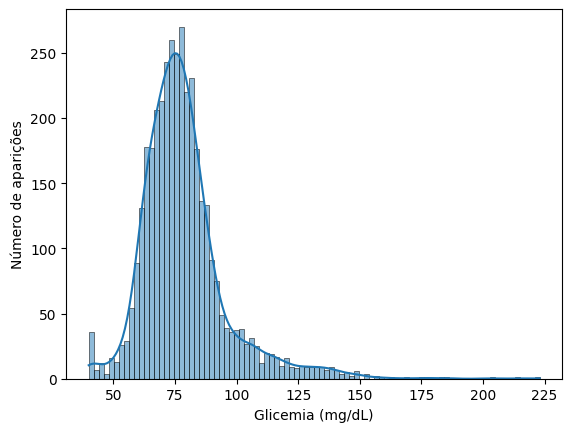

In [15]:
print('Quantidade de aparições dos valores medidos de glicemia (mg/dL)')
sns.histplot(df_raw['value'], kde=True)
plt.ylabel('Número de aparições')
plt.xlabel('Glicemia (mg/dL)')

In [16]:
# Assimetria positiva indica cauda mais longa à direita
print("Assimetria:", df_raw['value'].skew())

# Curtose acima de 3 indica caudas mais "pesadas" que as de uma distribuição normal 
# (com mais valores extremos do que seriam esperados em dados gerados de uma normal)
print("Curtose:", df_raw['value'].kurt())

Assimetria: 1.7684318929557772
Curtose: 6.560482423430236


## 3. Estatísticas diárias de 'value'

Quantidade de medições por dia da semana


Text(0.5, 0, 'Dia da semana')

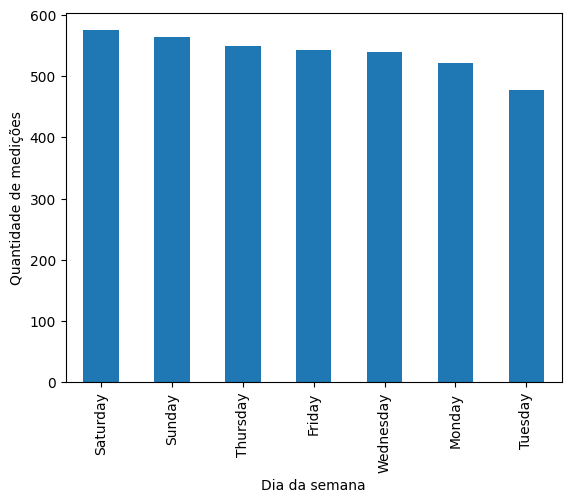

In [17]:
print('Quantidade de medições por dia da semana')
df_raw['weekday'].value_counts().plot.bar()
plt.ylabel('Quantidade de medições')
plt.xlabel('Dia da semana')

C:\Users\laris\AppData\Local\Temp\ipykernel_36028\2523634315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['date_str'] = df_raw['date'].dt.strftime('%Y-%m-%d')  # ou '%d/%m/%Y' se preferir


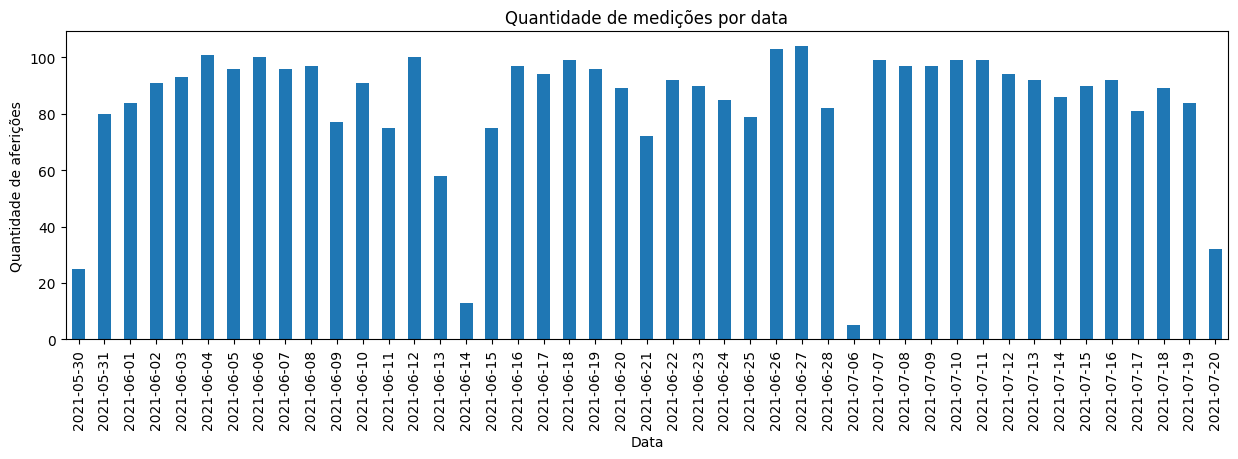

In [18]:
df_raw['date_str'] = df_raw['date'].dt.strftime('%Y-%m-%d')  # ou '%d/%m/%Y' se preferir
df_raw.groupby('date_str').size().plot(
    kind='bar', figsize=(15, 4), title='Quantidade de medições por data'
)
plt.ylabel('Quantidade de aferições')
plt.xlabel('Data')
plt.show()

Abaixo, temos a média por dia, mas com um porém: mesmo considerando dias com mais de 64 medições, ainda podem haver dias com medições irregulares, que não contemplem todos os ciclos do dia!

Média das medições nos dias em que houve aferição


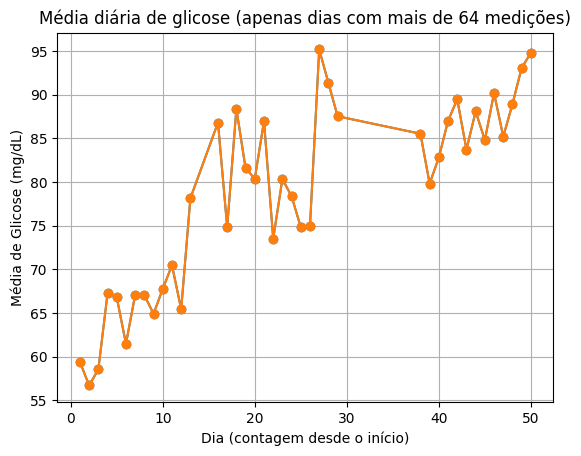

In [19]:
print('Média das medições nos dias em que houve aferição')
contagem_por_dia = df_raw.groupby('date_cont')['value'].count()
dias_validos = contagem_por_dia[contagem_por_dia > 64].index
media_filtrada = df_raw[df_raw['date_cont'].isin(dias_validos)].groupby('date_cont')['value'].mean()

# Plota a média diária apenas para os dias com mais de 64 medições
media_filtrada.plot(marker='o', linestyle='-')

x = media_filtrada.index          # números do dia: 0, 1, 3, 10, etc.
y = media_filtrada.values         # médias de glicose

# Plotando com espaçamento proporcional
plt.plot(x, y, marker='o', linestyle='-')

# Rótulos dos eixos
plt.xlabel('Dia (contagem desde o início)')
plt.ylabel('Média de Glicose (mg/dL)')
plt.title(f'Média diária de glicose (apenas dias com mais de 64 medições)')

# Ativar grade
plt.grid(True)

plt.show()

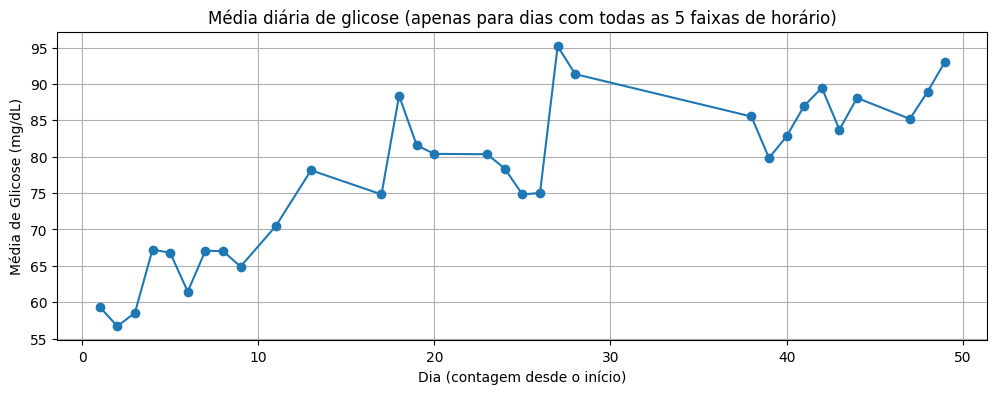

In [20]:
# Contar quantas faixas únicas existem por dia
faixas_por_dia = df_raw.groupby('date_cont')['time_of_day'].nunique()

# Selecionar apenas os dias que têm todas as 5 faixas
dias_completo = faixas_por_dia[faixas_por_dia == 5].index

media_filtrada = df_raw[df_raw['date_cont'].isin(dias_completo)].groupby('date_cont')['value'].mean()
plt.figure(figsize=(12,4))
plt.plot(media_filtrada.index, media_filtrada.values, marker='o', linestyle='-')
plt.xlabel('Dia (contagem desde o início)')
plt.ylabel('Média de Glicose (mg/dL)')
plt.title('Média diária de glicose (apenas para dias com todas as 5 faixas de horário)')
plt.grid(True)
plt.show()

Quantidade de medições por hora


Text(0.5, 0, 'Hora do dia')

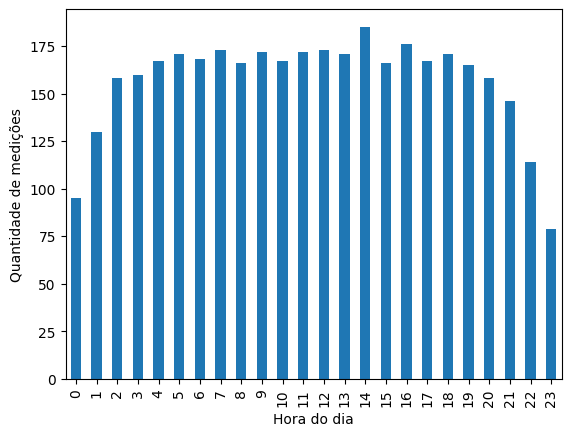

In [21]:
print('Quantidade de medições por hora')
contagem_horas_ord = df_raw['hour'].value_counts().sort_index()
contagem_horas_ord.plot.bar()
plt.ylabel('Quantidade de medições')
plt.xlabel('Hora do dia')

<div style="text-align: center;">

## 👀 Algumas questões importantes

</div>



### 1️⃣ Há relação entre o valor da glicemia (value) e o horário do dia (time)? Em quais horas do dia há maiores picos de glicemia? Em quais horas do dia há menores valores de glicemia? 


In [22]:
# Valores de média, mínimo e máximo valores de glicemia (mg/dL) por hora do dia
df_raw.groupby('hour')['value'].agg(['mean', 'median', 'min', 'max']).round(1)

,mean,median,min,max
hour,,,,
0,74.7,78.0,40.0,100.0
1,74.2,75.0,40.0,113.0
2,71.8,73.0,40.0,107.0
3,69.6,70.0,40.0,93.0
4,68.3,69.0,40.0,90.0
5,67.9,69.0,40.0,91.0
6,68.1,69.0,40.0,91.0
7,70.4,71.0,40.0,118.0
8,74.0,72.5,45.0,136.0


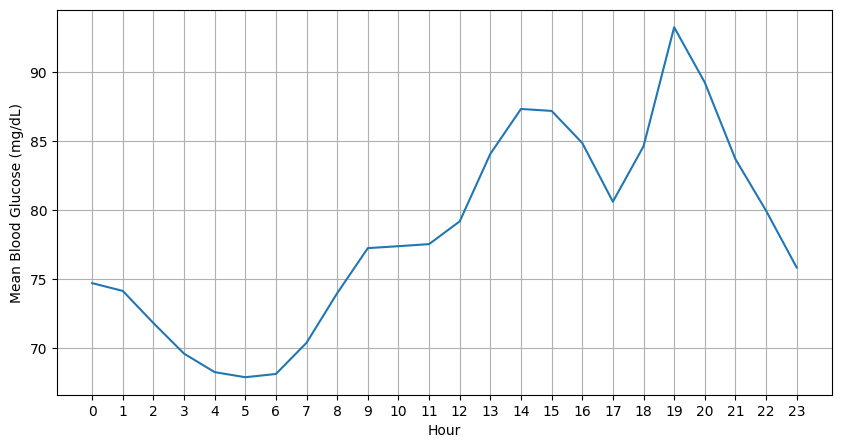

In [23]:
# Gráfico da média de glicemia por hora do dia 
media_por_hora = df_raw.groupby('hour')['value'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=media_por_hora.index, y=media_por_hora.values)
plt.xlabel('Hour')
plt.ylabel('Mean Blood Glucose (mg/dL)')
plt.grid(True)
plt.xticks(range(24))
plt.show()

### 2️⃣ Nos dados analisados, o paciente está dentro da porcentagem de tempo ideal para cada intervalo de referência? 

##### Porcentagem de tempo ideal em cada intervalo de referência:
- TIR time in range: ≥ 70% do tempo entre 70-180 mg/dL
- TBR time below range: < 4% do tempo abaixo de 70 mg/dL
- TVBR time very below range: < 1% abaixo de 54 mg/dL
- TAR time above range: < 25% acima de 180 mg/dL

In [24]:
total = len(df_raw)
tar = len(df_raw[df_raw['value'] > 180]) / total * 100
tir = len(df_raw[(df_raw['value'] >= 70) & (df_raw['value'] <= 180)]) / total * 100
tbr = len(df_raw[df_raw['value'] < 70]) / total * 100
tvbr = len(df_raw[df_raw['value'] < 54]) / total * 100

In [25]:
tar_check = '✔️' if tar < 25 else '❌'
tir_check = '✔️' if tir >= 70 else '❌'
tbr_check = '✔️' if tbr < 4 else '❌'
tvbr_check = '✔️' if tvbr < 1 else '❌'

In [26]:
print(f'| TAR time above range      | {tar:.1f}%  | < 25% acima de 180 mg/dL           | {tar_check} |')
print(f'| TIR time in range         | {tir:.1f}% |  ≥ 70% do tempo entre 70-180 mg/dL | {tir_check} |')
print(f'| TBR time below range      | {tbr:.1f}% | < 4% do tempo abaixo de 70 mg/dL   | {tbr_check} |')
print(f'| TBR time very below range | {tvbr:.1f}%  | < 1% abaixo de 54 mg/dL            | {tvbr_check} |')

| TAR time above range      | 0.1%  | < 25% acima de 180 mg/dL           | ✔️ |
| TIR time in range         | 71.0% |  ≥ 70% do tempo entre 70-180 mg/dL | ✔️ |
| TBR time below range      | 28.9% | < 4% do tempo abaixo de 70 mg/dL   | ❌ |
| TBR time very below range | 2.7%  | < 1% abaixo de 54 mg/dL            | ❌ |


### 3️⃣ Há diferença significativa da média de glicemia entre dias da semana (dias úteis, fins de semana)?

C:\Users\laris\AppData\Local\Temp\ipykernel_36028\1376665610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['weekday_cat'] = pd.Categorical(df_raw['weekday'], categories=dias_ordem, ordered=True)
C:\Users\laris\AppData\Local\Temp\ipykernel_36028\1376665610.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_por_dia = df_raw.groupby('weekday_cat')['value'].mean().reset_index()


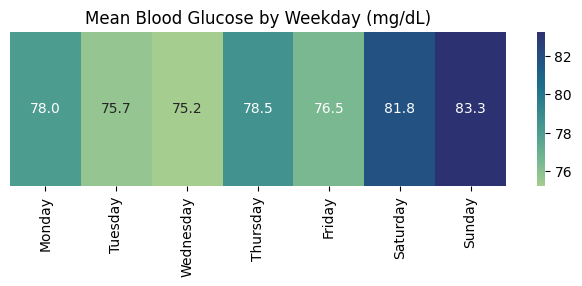

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo a ordem dos dias da semana
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Transformando a coluna weekday em categorical, com ordem correta
df_raw['weekday_cat'] = pd.Categorical(df_raw['weekday'], categories=dias_ordem, ordered=True)

# Calculando a média por dia da semana
media_por_dia = df_raw.groupby('weekday_cat')['value'].mean().reset_index()

# Criando o DataFrame para heatmap
mapa_mediageral = pd.DataFrame([media_por_dia['value'].values], columns=media_por_dia['weekday_cat'].values)

# Plotando!
plt.figure(figsize=(8, 2))
sns.heatmap(
    mapa_mediageral,
    annot=True,
    fmt=".1f",
    cmap="crest",
    
)
plt.title("Mean Blood Glucose by Weekday (mg/dL)")
plt.yticks([], []) 
plt.show()

C:\Users\laris\AppData\Local\Temp\ipykernel_36028\3134644153.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['time_of_day_cat'] = pd.Categorical(df_raw['time_of_day'], categories=time_of_day_order, ordered=True)
C:\Users\laris\AppData\Local\Temp\ipykernel_36028\3134644153.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabela = df_raw.pivot_table(


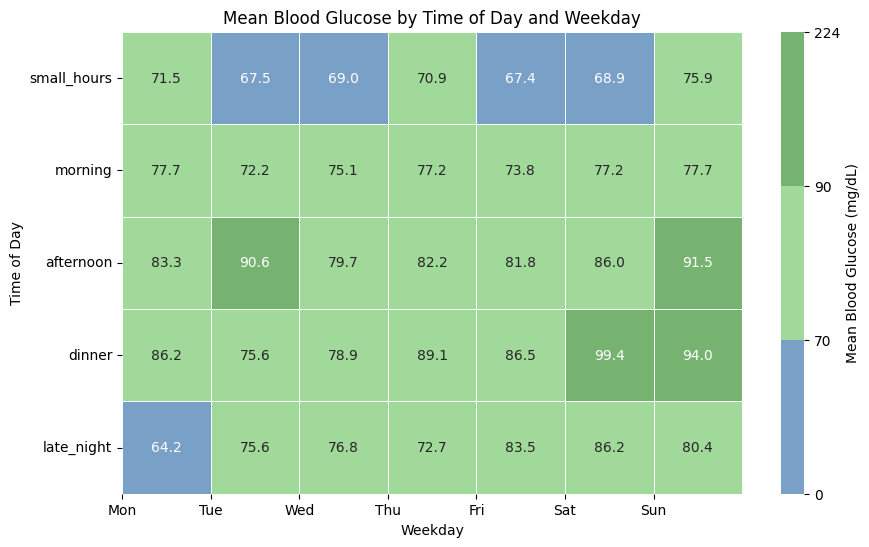

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


# Mapeando as faixas do dia como categorias ordenadas
time_of_day_order = ['small_hours', 'morning', 'afternoon', 'dinner', 'late_night']
df_raw['time_of_day_cat'] = pd.Categorical(df_raw['time_of_day'], categories=time_of_day_order, ordered=True)

# Pivot table: faixas x dias da semana
tabela = df_raw.pivot_table(
    index='time_of_day_cat',
    columns='weekday_cat',
    values='value',
    aggfunc='mean'
)

# Garantindo todas as faixas
tabela = tabela.reindex(time_of_day_order)

# Definindo cores e limites
glucose_range = [0, 70, 90, df_raw['value'].max() + 1]  # 3 intervalos → 3 cores
colors = ["#79A0C7", '#A1D99B', "#77B370"]  # lilás, azul, verde
cmap = ListedColormap(colors)
norm = BoundaryNorm(glucose_range, ncolors=len(colors))

# Dias da semana em inglês
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plotando!!
plt.figure(figsize=(10, 6))
sns.heatmap(
    tabela,
    annot=True,
    fmt=".1f",
    cmap=cmap,
    norm=norm,
    cbar_kws={'label': 'Mean Blood Glucose (mg/dL)'},
    linecolor='white',
    linewidths=0.5
)

# Centralizando os labels do eixo X
plt.xticks(ticks=range(7), labels=weekday_labels, ha='center')
plt.yticks(rotation=0)
plt.title("Mean Blood Glucose by Time of Day and Weekday")
plt.ylabel("Time of Day")
plt.xlabel("Weekday")
plt.show()

### 4️⃣ Há alguma diferença entre a média da primeira e última metade da amostra? Houve alguma diferença no controle ao longo do mês ou permaneceu constante?

In [29]:
# Número total de medições
n = len(df_raw)

# Dividindo em duas metades
primeira_meta = df_raw['value'][:n//2]  # da primeira até a metade
segunda_meta = df_raw['value'][n//2:]   # da metade até o final

# Calculando médias
media_primeira = primeira_meta.mean()
media_segunda = segunda_meta.mean()

print("Média da primeira metade:", media_primeira)
print("Média da segunda metade:", media_segunda)

Média da primeira metade: 71.30132625994695
Média da segunda metade: 85.78461538461538


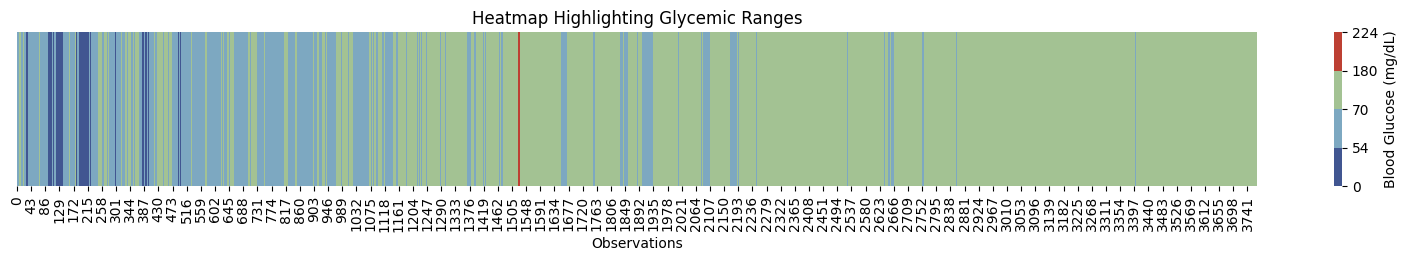

In [30]:
from matplotlib.colors import ListedColormap, BoundaryNorm

mapa_medicoes = df_raw[['value']]
mapa_medicoes = mapa_medicoes.T

faixas = [0, 54, 70, 180, df_raw['value'].max() + 1]

# Cores suaves e harmônicas:
colors = ["#415691","#7DA8C1", '#A3C293', "#BD4033"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(faixas, cmap.N)

# Plot
plt.figure(figsize=(20, 2))
sns.heatmap(mapa_medicoes, cmap=cmap, norm=norm, cbar_kws={'label': 'Blood Glucose (mg/dL)'})
plt.yticks([], [])
plt.xlabel("Observations")
plt.title("Heatmap Highlighting Glycemic Ranges")
plt.show()

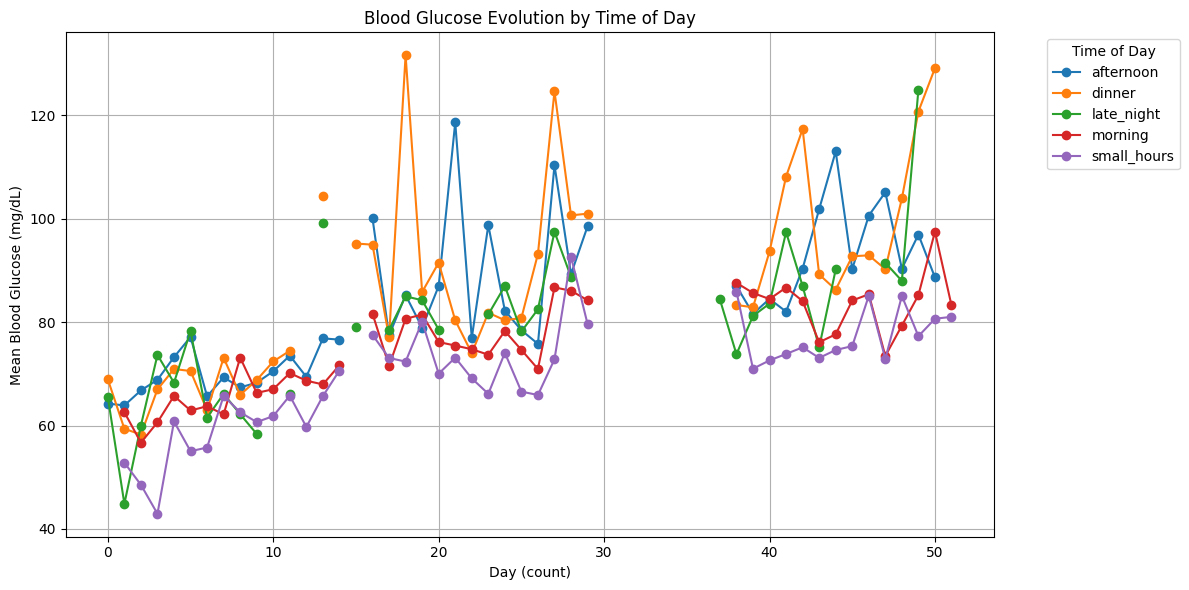

In [31]:
media_por_faixa = df_raw.groupby(['date_cont', 'time_of_day'])['value'].mean().unstack()

media_por_faixa.plot(figsize=(12, 6), marker='o')

plt.xlabel('Day (count)')
plt.ylabel('Mean Blood Glucose (mg/dL)')
plt.title('Blood Glucose Evolution by Time of Day')
plt.grid(True)
plt.legend(title='Time of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Predição com regressão linear

In [32]:
#%pip install scikit-learn

In [33]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [34]:
x = df_raw[['hour']]
y = df_raw['value']

In [35]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=42)

In [36]:
modelo = LinearRegression()
modelo.fit(x_treino, y_treino)


LinearRegression()

In [37]:
y_pred = modelo.predict(x_teste)
rmse = np.sqrt(mean_squared_error(y_teste, y_pred))

print("Coeficiente angular (slope):", modelo.coef_[0])
print("Intercepto:", modelo.intercept_)
print("R²:", r2_score(y_teste, y_pred))
print("RMSE:", rmse)

Coeficiente angular (slope): 0.8985565905147452
Intercepto: 68.50591131271837
R²: 0.10076012329141049
RMSE: 15.834548423840197


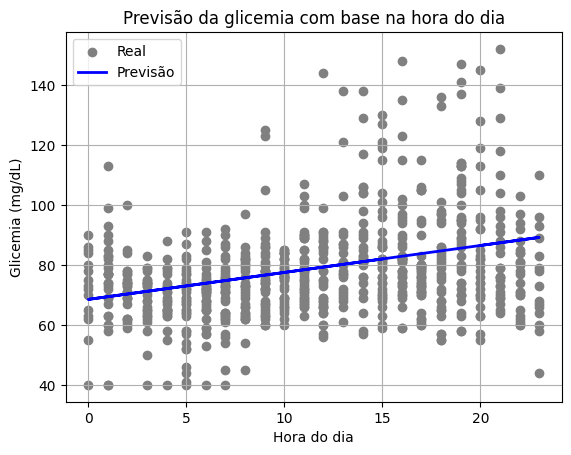

In [38]:
plt.scatter(x_teste, y_teste, color='gray', label='Real')
plt.plot(x_teste, y_pred, color='blue', linewidth=2, label='Previsão')
plt.title('Previsão da glicemia com base na hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Glicemia (mg/dL)')
plt.legend()
plt.grid(True)
plt.show()